In [1]:
from sklearn.pipeline import FeatureUnion

# impoerting the libraries for nlp using tfid and count vectorizer from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# import libraries from sklearn for model selection and evaluation and pipeline creation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

# impoeing basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# importing TfidfTransformer, SimpleImputer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.base import BaseEstimator, TransformerMixin

# import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

# import LogisticRegression
from sklearn.linear_model import LogisticRegression

# import ColumnTransformer
from sklearn.compose import ColumnTransformer


# import labelencoder
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score


In [2]:

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


In [3]:
from sklearn.base import TransformerMixin
from scipy.sparse import csr_matrix

class SparseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return csr_matrix(X)


from scipy.sparse import csr_matrix
from scipy.sparse import hstack
# from scipy.sparse import vstack




In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import FeatureUnion, Pipeline

class CountVectorizerTfidfTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.count_vectorizer = CountVectorizer(ngram_range=(1, 2))
        self.tfidf_transformer = TfidfTransformer()

    def fit(self, X, y=None):
        # Fit the CountVectorizer and TfidfTransformer on the data
        self.count_vectorizer.fit(X)
        self.tfidf_transformer.fit(self.count_vectorizer.transform(X))
        return self

    def transform(self, X):
        # Apply CountVectorizer and TfidfTransformer sequentially
        X_count = self.count_vectorizer.transform(X)
        X_tfidf = self.tfidf_transformer.transform(X_count)
        return X_tfidf


In [5]:
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

class ImputeAndStandardizeTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='median')
        self.scaler = StandardScaler()
        self.to_sparse = SparseTransformer()
        
    def fit(self, X, y=None):
        # Fit the imputer and scaler on the data
        self.imputer.fit(X)
        self.scaler.fit(X)
        return self
    
    def transform(self, X):
        # Impute missing values
        X_imputed = self.imputer.transform(X)
        
        # Standardize the column
        X_standardized = self.scaler.transform(X_imputed)

        X_sparse = self.to_sparse.transform(X_standardized)
        
        return X_sparse


In [6]:
# import the dataset
df = pd.read_csv('./../data/reza_transactions.csv')

df = df[df['Cost']>0]

# drop the columns that are not needed
df = df[['Item', 'Cost', 'Type']].rename(columns={'Item': 'text', 'Cost': 'amount', 'Type': 'label'})

In [7]:
labels_counts = df['label'].value_counts(ascending=False)# .plot(kind='bar')

print(f"There are {len(labels_counts)} labels in the dataset", end=' ')

labels_counts = labels_counts[labels_counts>5]

labels = labels_counts.index.tolist()

print(f"and {len(labels_counts)} labels in the dataset with more than 5 samples")


There are 24 labels in the dataset and 19 labels in the dataset with more than 5 samples


In [8]:
df[df['label'].isin(labels)].shape[0]/df.shape[0]

0.9972620050547599

In [9]:
df = df[df['label'].isin(labels)]

In [10]:
X = df[['amount', 'text']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:


encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train.values)
y_test = encoder.transform(y_test.values)


In [12]:
numerical_transformer = ImputeAndStandardizeTransformer()
text_transformer = CountVectorizerTfidfTransformer()

X_amount_train = numerical_transformer.fit_transform(
    X=X_train['amount'].values.reshape(-1, 1)
)

X_text_train = text_transformer.fit_transform(
    X=X_train['text'].values
)

X_amount_test = numerical_transformer.transform(
    X=X_test['amount'].values.reshape(-1, 1)
)

X_text_test =text_transformer.transform(
    X=X_test['text'].values
)

In [13]:
X_train = hstack([
    X_amount_train,
    X_text_train,
])


X_test = hstack([
    X_amount_test,
    X_text_test,
])



In [14]:
# classifier = LogisticRegression(solver='liblinear', multi_class='auto')


from xgboost import XGBClassifier

classifier = XGBClassifier()

classifier.fit(
    X = X_train,
    y=y_train,
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [15]:
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)


#calculate accuracy
accuracy_train = accuracy_score(
    y_train,
    y_pred_train)

accuracy_train

#calculate accuracy
accuracy_test = accuracy_score(
    y_test,
    y_pred_test
    )

accuracy_train, accuracy_test

(0.9157866948257656, 0.7898627243928195)

In [16]:
result_df = pd.DataFrame({"actual":y_test, "prediction":y_pred_test})
result_df['actual'] = encoder.inverse_transform(result_df['actual'])
result_df['prediction'] = encoder.inverse_transform(result_df['prediction'])

result_df.head()


,actual,prediction
0,Grocery,Grocery
1,Restaurant,Restaurant
2,Mortgage,Mortgage
3,Items,Tools
4,Restaurant,Parking


In [22]:
result_df['correct_prediction'] = (result_df['actual'] == result_df['prediction']).map({True: 'correct', False: 'wrong'})

result_df.assign(cnt=1).groupby(['actual', 'prediction'])['cnt'].sum().reset_index()

result_df['correct_prediction'] = (result_df['actual'] == result_df['prediction']).map({True: 'correct', False: 'wrong'})

result_df['total_count'] = result_df.groupby(['actual', 'correct_prediction'])['correct_prediction'].transform('count')

# result_df.groupby(['actual', 'correct_prediction'])['total_count'].size().unstack().plot(kind='bar', stacked=True, figsize=(10,6))

resulf_pivot_df = result_df.groupby(['actual', 'correct_prediction'])['total_count'].size().unstack().fillna(0) #.apply(lambda x: x/x.sum(), axis=1) #.plot(kind='bar', stacked=True, figsize=(10,6))

resulf_pivot_df['total'] = resulf_pivot_df['correct'] + resulf_pivot_df['wrong']

# resulf_pivot_df = resulf_pivot_df.sort_values(by='total', ascending=False)


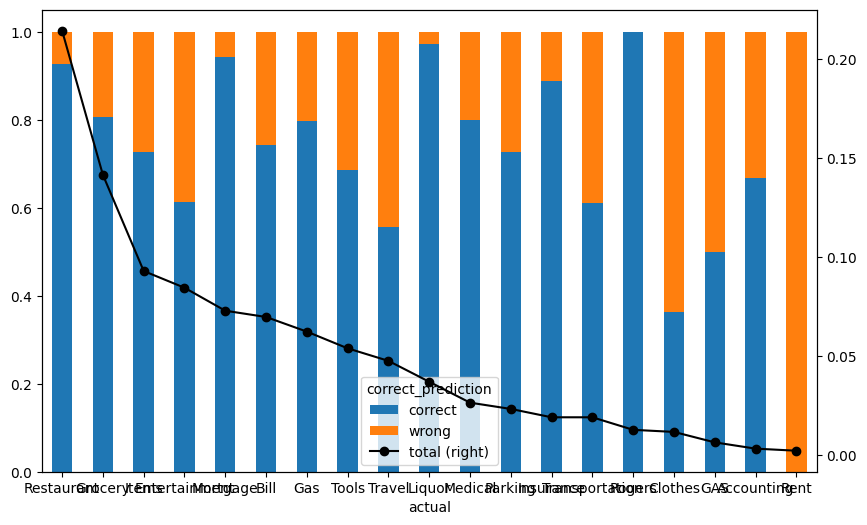

In [23]:
resulf_pivot_df[['correct', 'wrong']] = resulf_pivot_df[['correct', 'wrong']].div(resulf_pivot_df['total'], axis=0)

fig, ax = plt.subplots(figsize=(20,6))

resulf_pivot_df = resulf_pivot_df.sort_values(by='total', ascending=False)

resulf_pivot_df[['correct', 'wrong']].plot(kind='bar', stacked=True, figsize=(10,6), ax=ax)

resulf_pivot_df[['total']] = resulf_pivot_df[['total']]/resulf_pivot_df[['total']].sum()

# add total column as a line to the plot on secondary axis
ax = resulf_pivot_df[['total']].plot(kind='line', secondary_y=True, figsize=(10,6), ax=ax, color='black', marker='o')
# resulf_pivot_df[['correct', 'wrong']].plot(kind='bar', stacked=True, figsize=(10,6))

In [18]:

classifier.fit(
    X = X_text_train,
    y=y_train,
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [19]:
y_pred_train = classifier.predict(X_text_train)
y_pred_test = classifier.predict(X_text_test)


#calculate accuracy
accuracy_train_2 = accuracy_score(
    y_train,
    y_pred_train)

#calculate accuracy
accuracy_test_2 = accuracy_score(
    y_test,
    y_pred_test
    )

In [20]:


accuracy_train_2, accuracy_test_2

(0.8099260823653643, 0.7360084477296727)

In [21]:
result_df = pd.DataFrame(
    {'all_features': [accuracy_train, accuracy_test],
     'text_feature': [accuracy_train_2, accuracy_test_2],
     }
)

<Axes: >

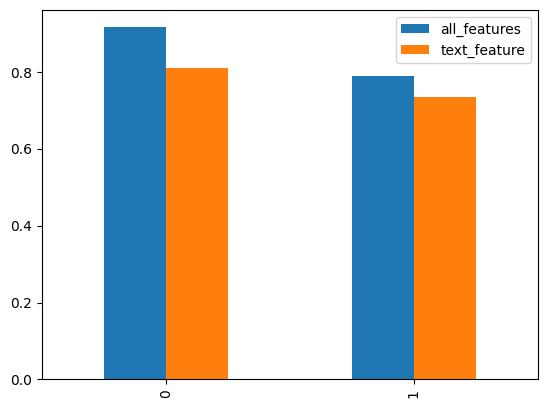

In [22]:
result_df.plot(kind='bar')

In [23]:
result_df

,all_features,text_feature
0,0.915787,0.809926
1,0.789863,0.736008


In [24]:
from hyperopt import hp, fmin, tpe, Trials
from xgboost import XGBClassifier
from hyperopt import space_eval
from pprint import pprint

import numpy as np

# Define the search space for Bayesian optimization
param_space = {
    'n_estimators' : hp.choice('n_estimators', range(75, 125, 25)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1)),
    'max_depth': hp.choice('max_depth', [3, 4, 5, 6]),
    'subsample': hp.uniform('subsample', 0.8, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.8, 1.0),
}

# Create an objective function for hyperopt
def objective(params):
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    return -accuracy  # Minimize negative accuracy

# Perform Bayesian hyperparameter search
trials = Trials()
best = fmin(objective, param_space, algo=tpe.suggest, max_evals=20, trials=trials)

# Get the best hyperparameters
best_params = space_eval(param_space, best)
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Evaluate the best model on the test set
accuracy = best_model.score(X_test, y_test)

print("Best hyperparameters:", best_params)
print("\n")
print("Accuracy on test set:", accuracy)


 65%|██████▌   | 13/20 [00:23<00:14,  2.03s/trial, best loss: -0.7845828933474129]

In [ ]:
best_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9122704231732942, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08775922046927734,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)


#calculate accuracy
accuracy_train_3 = accuracy_score(
    y_train,
    y_pred_train)

#calculate accuracy
accuracy_test_3 = accuracy_score(
    y_test,
    y_pred_test
    )

In [ ]:
result_df = pd.DataFrame(
    {
    'text_feature': [accuracy_train_2, accuracy_test_2],
    'all_features': [accuracy_train, accuracy_test],
    'best_model': [accuracy_train_3, accuracy_test_3],}
)

In [ ]:
result_df

,text_feature,all_features,best_model
0,0.809926,0.915787,0.825766
1,0.736008,0.789863,0.776135


<Axes: >

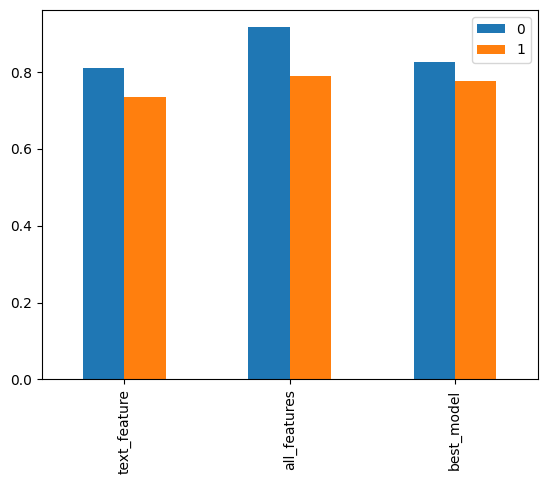

In [ ]:
result_df.transpose().plot(kind='bar')